## Imports

In [59]:
from mppca import MPPCA

In [60]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = torch.stack([x for x, y in train_dataset])
y_train = torch.tensor([y for x, y in train_dataset])

X_test = torch.stack([x for x, y in test_dataset])
y_test = torch.tensor([y for x, y in test_dataset])


# Each image are 28x28
print("Size of X_train :", X_train.shape)
print("Size of X_test  :", X_test.shape)

Size of X_train : torch.Size([60000, 784])
Size of X_test  : torch.Size([10000, 784])


## Training MPPCA on MNIST

In [ ]:
epochs = 2000
n_components = 3
k_mixtures = 12

n_train = 3000

pca = MPPCA(k_mixtures=k_mixtures, n_components=n_components, max_iter=epochs,stopping_criterion=1e-6)
pca.fit(X_train[:n_train,:])

MPPCA initialized with k_mixtures=12, n_components=2, method=em
Starting EM fitting on 2000 epochs...


EM - MPPCA:  39%|███▉      | 782/2000 [08:30<13:14,  1.53iter/s, loglik=592391.94]


## Sampling in MNIST with MPPCA

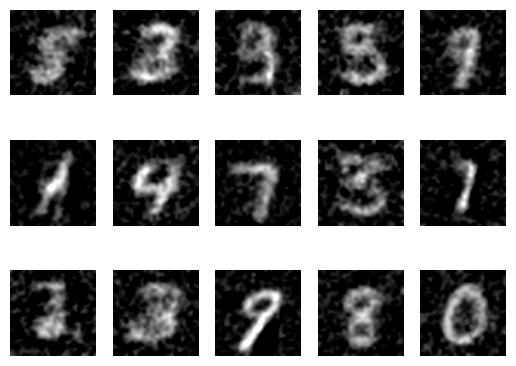

In [65]:
import matplotlib.pyplot as plt
import math
n_samples = 15
Xsamples,_ = pca.sample(n_samples)


n_cols = 5#math.ceil(math.sqrt(n_samples))
n_rows = 3#math.ceil(n_samples / n_cols)
fig,axs = plt.subplots(nrows=n_rows,ncols=n_cols)

for i in range(n_rows):
    for j in range(n_cols):
        axs[i,j].imshow(Xsamples[i + j*(n_rows)].reshape(28,28),cmap='gray', interpolation='bicubic', vmin=0, vmax=1)
        axs[i,j].set_axis_off()

## Inference on missing data with MPPCA

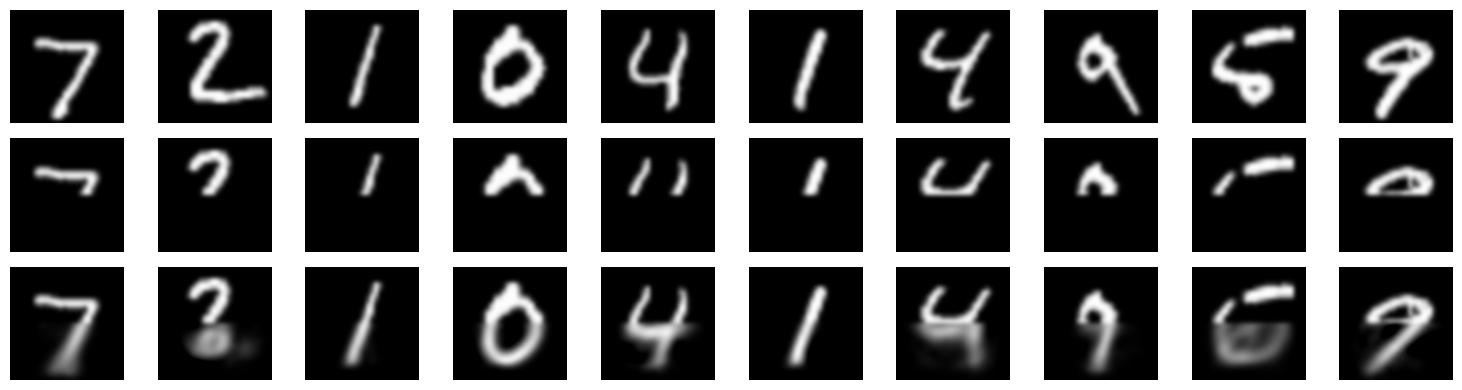

In [66]:
img_size = X_train[0,:].shape[0]
obs_mask=torch.tensor([True]*(img_size//2) + [False]*(img_size//2))

n_figs = 10
fig,axs = plt.subplots(3,n_figs,figsize=(15,4))
for i in range(n_figs):
    Xcorr = pca.infer_missingdata(X_test[i],obs_mask=obs_mask)
    Xsplit = torch.vstack([X_test[i][:img_size//2],torch.zeros(img_size//2)])

    axs[0,i].imshow(X_test[i].reshape(28,28),cmap="gray", interpolation='bicubic', vmin=0, vmax=1)
    axs[0,i].set_axis_off()
    axs[1,i].imshow(Xsplit.reshape(28,28),cmap="gray", interpolation='bicubic', vmin=0, vmax=1)
    axs[1,i].set_axis_off()
    axs[2,i].imshow(Xcorr.reshape(28,28),cmap="gray", interpolation='bicubic', vmin=0, vmax=1)
    axs[2,i].set_axis_off()

plt.tight_layout()

## Clustering in the latent space

ARI Score: 0.05944476351057804


Text(0.5, 0.98, 'Clustered data')

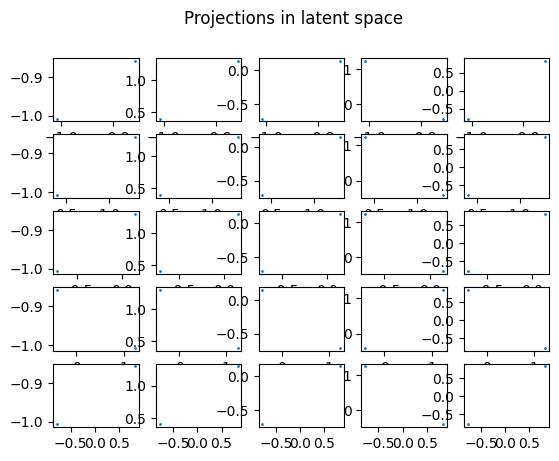

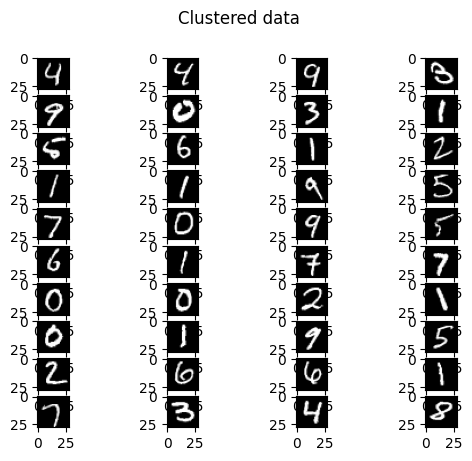

In [67]:
n_range = 5000
Z,ks = pca.transform(X_test[:n_range])
true_labels = y_test[:n_range]

n_proj = 5
m_proj = 5
fig,axs = plt.subplots(n_proj,m_proj)

for i in range(n_proj):
    for j in range(m_proj):
        axs[i,j].scatter(Z[i,:],Z[j,:],s=1)

plt.suptitle("Projections in latent space")

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

K = 10
kmeans= KMeans(
    n_clusters = K,
    init="k-means++",
    n_init=10,
)

pred_labels = kmeans.fit_predict(Z.detach().cpu().numpy())
ari = adjusted_rand_score(true_labels, pred_labels)
print("ARI Score:", ari)

n_plots = 4
unique_labels = np.unique(pred_labels)
fig,axs = plt.subplots(len(unique_labels),n_plots)
for i in unique_labels:
    idx_candidats = (pred_labels == i)
    candidats = X_test[:n_range][idx_candidats,:]
    for j in range(min(len(candidats),n_plots)):
        axs[i,j].imshow(candidats[j].reshape(28,28),cmap="gray")
plt.suptitle("Clustered data")